# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 9

In [3]:
INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "gls-1000g_mashr-test-full_corr"
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(9000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.006443,0.009288,0.693660,0.487920,0.243960,random.pheno988
1,LV234,0.000004,0.000223,0.019273,0.984624,0.492312,random.pheno988
2,LV847,-0.000999,0.011045,-0.090416,0.927959,0.536020,random.pheno988
3,LV110,-0.019925,0.010094,-1.974046,0.048419,0.975790,random.pheno988
4,LV769,0.000036,0.000484,0.074986,0.940228,0.470114,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.02811111111111111

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(9, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV110,0.010,0.047,0.081
1,LV234,0.000,0.000,0.000
2,LV412,0.000,0.000,0.000
3,LV45,0.053,0.116,0.161
4,LV57,0.000,0.000,0.000


In [21]:
summary_df.describe()

,1,5,10
count,9.000000,9.000000,9.000000
mean,0.008667,0.028111,0.045889
std,0.017139,0.039892,0.059438
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.009000,0.047000,0.081000
max,0.053000,0.116000,0.161000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(0, 4)

,lv,1,5,10


,lv,1,5,10


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(1, 4)

,lv,1,5,10
3,LV45,0.053,0.116,0.161


Many LVs have a mean type I error greater than expected.

LV45 has the largest mean type I error (0.158). Let's take a look at these LVs with poor mean type I errors.

# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.006443,0.009288,0.693660,0.487920,0.243960,random.pheno988
9,LV45,0.004795,0.009352,0.512760,0.608137,0.304068,random.pheno589
18,LV45,0.001970,0.009262,0.212721,0.831551,0.415776,random.pheno385
27,LV45,0.004231,0.009399,0.450116,0.652642,0.326321,random.pheno5
36,LV45,-0.018276,0.009290,-1.967222,0.049201,0.975400,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.053

In [31]:
show_prop(results, 0.05)

0.116

In [32]:
show_prop(results, 0.10)

0.161

In [33]:
show_prop(results, 0.15)

0.197

In [34]:
show_prop(results, 0.20)

0.254

### QQplot

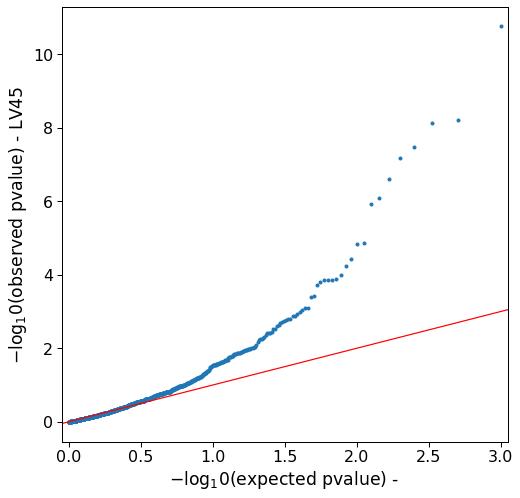

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
1,LV234,0.000004,0.000223,0.019273,0.984624,0.492312,random.pheno988
10,LV234,0.000002,0.000224,0.007053,0.994373,0.497187,random.pheno589
19,LV234,-0.000002,0.000222,-0.006912,0.994485,0.502757,random.pheno385
28,LV234,0.000002,0.000226,0.007817,0.993764,0.496882,random.pheno5
37,LV234,0.000002,0.000223,0.010348,0.991744,0.495872,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.0

In [42]:
show_prop(results, 0.05)

0.0

In [43]:
show_prop(results, 0.10)

0.0

In [44]:
show_prop(results, 0.15)

0.0

In [45]:
show_prop(results, 0.20)

0.0

### QQplot

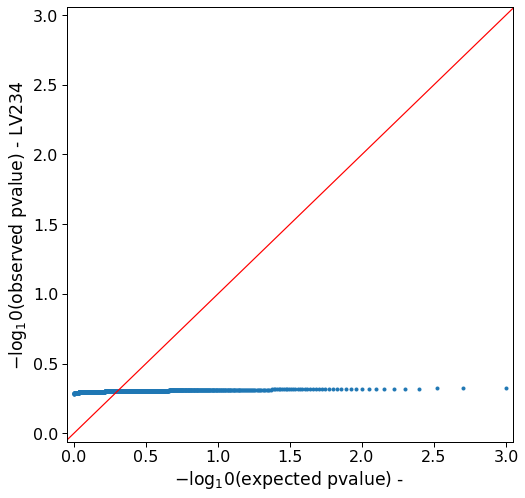

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV847,-0.000999,0.011045,-0.090416,0.927959,0.536020,random.pheno988
11,LV847,-0.002665,0.011121,-0.239661,0.810601,0.594700,random.pheno589
20,LV847,-0.013035,0.011012,-1.183693,0.236578,0.881711,random.pheno385
29,LV847,-0.004398,0.011177,-0.393476,0.693981,0.653010,random.pheno5
38,LV847,0.008365,0.011050,0.756978,0.449091,0.224545,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.009

In [53]:
show_prop(results, 0.05)

0.053

In [54]:
show_prop(results, 0.10)

0.093

In [55]:
show_prop(results, 0.15)

0.13

In [56]:
show_prop(results, 0.20)

0.177

### QQplot

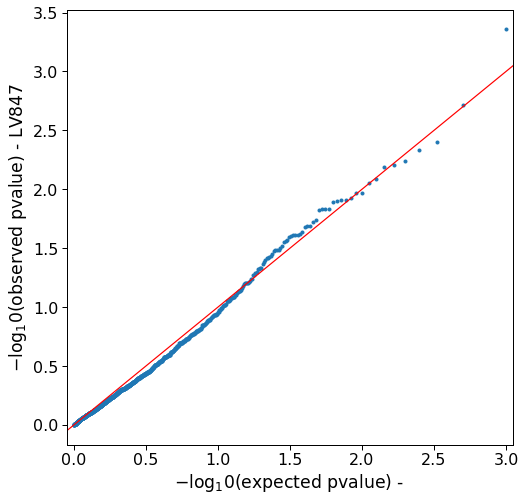

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
3,LV110,-0.019925,0.010094,-1.974046,0.048419,0.975790,random.pheno988
12,LV110,-0.016261,0.010164,-1.599927,0.109664,0.945168,random.pheno589
21,LV110,-0.011648,0.010067,-1.157111,0.247270,0.876365,random.pheno385
30,LV110,-0.009312,0.010217,-0.911457,0.362089,0.818956,random.pheno5
39,LV110,0.009411,0.010101,0.931643,0.351556,0.175778,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.01

In [64]:
show_prop(results, 0.05)

0.047

In [65]:
show_prop(results, 0.10)

0.081

In [66]:
show_prop(results, 0.15)

0.128

In [67]:
show_prop(results, 0.20)

0.181

### QQplot

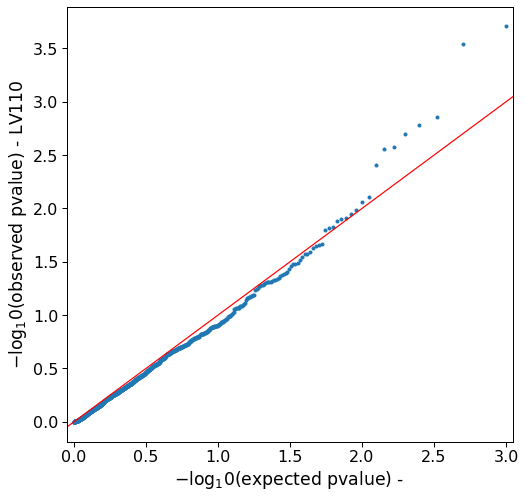

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV769,0.000036,0.000484,0.074986,0.940228,0.470114,random.pheno988
13,LV769,0.000002,0.000488,0.003849,0.996929,0.498464,random.pheno589
22,LV769,-0.000013,0.000483,-0.026184,0.979111,0.510444,random.pheno385
31,LV769,-0.000031,0.000490,-0.063330,0.949506,0.525247,random.pheno5
40,LV769,-0.000031,0.000485,-0.064870,0.948280,0.525860,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.0

In [75]:
show_prop(results, 0.05)

0.0

In [76]:
show_prop(results, 0.10)

0.0

In [77]:
show_prop(results, 0.15)

0.0

In [78]:
show_prop(results, 0.20)

0.0

### QQplot

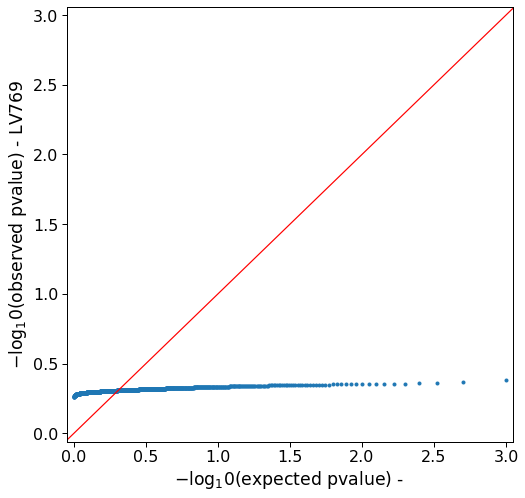

In [79]:
qqplot_unif(results)

The QQplot here is not the same as the LVs before. In previous LVs, there are very small pvalues, likely because of the genes from the same region at the top of the LV.

Here p-values are consistently smaller than expected, but there are no very small p-values.

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
5,LV800,0.000004,0.000303,0.012916,0.989695,0.494848,random.pheno988
14,LV800,-0.000009,0.000305,-0.027964,0.977692,0.511154,random.pheno589
23,LV800,-0.000003,0.000302,-0.009231,0.992635,0.503683,random.pheno385
32,LV800,-0.000008,0.000307,-0.027565,0.978010,0.510995,random.pheno5
41,LV800,-0.000006,0.000303,-0.020942,0.983293,0.508354,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.0

In [86]:
show_prop(results, 0.05)

0.0

In [87]:
show_prop(results, 0.10)

0.0

In [88]:
show_prop(results, 0.15)

0.0

In [89]:
show_prop(results, 0.20)

0.0

### QQplot

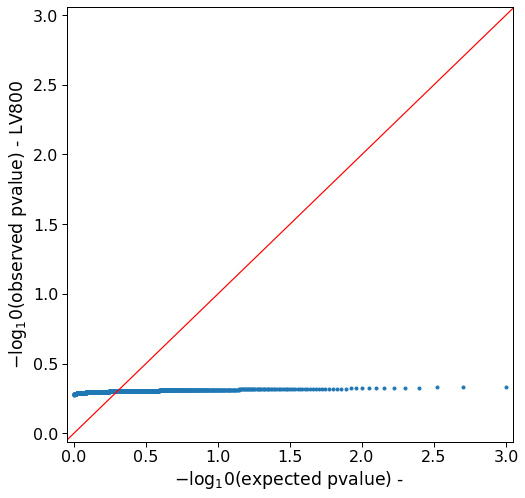

In [90]:
qqplot_unif(results)

**Note**: looks similar to LV769. This one has smaller minimum p-values.

## Notes

**TODO UPDATE**

There are LVs with high mean type I errors that have different properties:

1. LVs like LV45-LV110 (the first ones) have:
    1. Smaller minimum p-values (qqplots deviate late and quickly), with -log(p) around 10 or 20.
    1. High gene weights (around 6 to 9)...
    1. Genes from the same band at the top.
    1. Relatively fewer genes with non-zero (> 0) weights, from ~400 to ~1600.
    1. Cytobands usually have 1 or 2 genes with non-zero weight, but there are some with many genes.
        * LV45 has a single band with 13 genes, and all the rest have 8 or less...
        * ... whereas the rest of these LVs have many bands with many genes (this could explain why LV45 is the worst).

1. LVs like LV769 have:
    1. Larger p-values (qqplots deviate early) with -log10(p) around 4
    1. Lower gene weights (around 2 to 4).
    1. Genes at the top are not from the same band.
    1. Larger number of genes with non-zero (> 0) weights, more than 2400.
    1. Same pattern regarding cybands.

1. LVs like LV800 are mixed between the other two:
    1. QQ plots show early deviation but also smaller minimum pvalues.
    1. Lower gene weights (less than 2)
    1. Gene weights are a bit more uniform in LV800, with more genes having similar weights around 0.75 or 1.00.
    1. Genes at the top are from the same band.
    1. Same pattern regarding cybands.

Besides the ratio of genes with non-zero weights and zero, I didn't find any distinction **among genes with zero weight**.

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
6,LV412,1.109040e-08,0.000026,0.000423,0.999662,0.499831,random.pheno988
15,LV412,-4.931564e-08,0.000026,-0.001869,0.998509,0.500746,random.pheno589
24,LV412,3.591311e-08,0.000026,0.001374,0.998904,0.499452,random.pheno385
33,LV412,-1.683753e-08,0.000027,-0.000635,0.999494,0.500253,random.pheno5
42,LV412,6.636812e-08,0.000026,0.002531,0.997981,0.498990,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.0

In [99]:
show_prop(results, 0.05)

0.0

In [100]:
show_prop(results, 0.10)

0.0

In [101]:
show_prop(results, 0.15)

0.0

In [102]:
show_prop(results, 0.20)

0.0

### QQplot

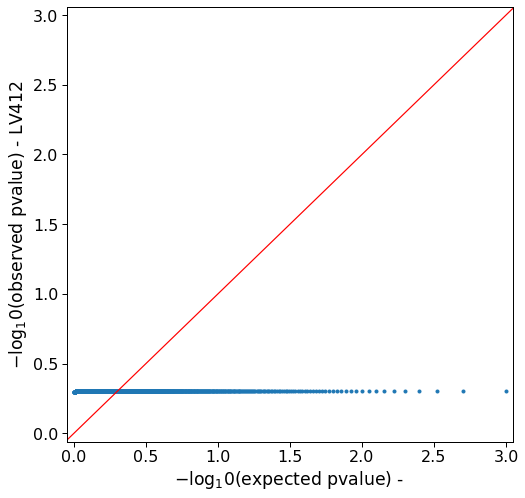

In [103]:
qqplot_unif(results)

**Note**

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
7,LV57,-1.115032e-05,0.000243,-0.045967,0.963338,0.518331,random.pheno988
16,LV57,6.401997e-07,0.000244,0.002621,0.997909,0.498954,random.pheno589
25,LV57,1.277858e-05,0.000242,0.052831,0.957868,0.478934,random.pheno385
34,LV57,-2.200574e-06,0.000245,-0.008965,0.992848,0.503576,random.pheno5
43,LV57,-6.151740e-07,0.000243,-0.002535,0.997978,0.501011,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.0

In [110]:
show_prop(results, 0.05)

0.0

In [111]:
show_prop(results, 0.10)

0.0

In [112]:
show_prop(results, 0.15)

0.0

In [113]:
show_prop(results, 0.20)

0.0

### QQplot

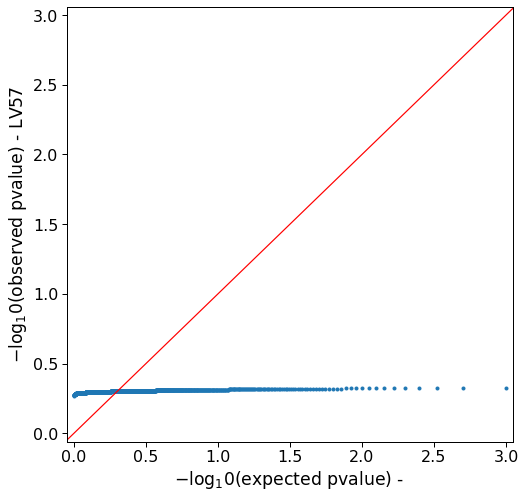

In [114]:
qqplot_unif(results)

**Note**

Here the distribution do differ, this is more similar to LV769.

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
8,LV647,-0.006634,0.011444,-0.579678,0.562152,0.718924,random.pheno988
17,LV647,0.001188,0.011522,0.103074,0.917907,0.458954,random.pheno589
26,LV647,0.007990,0.011411,0.700214,0.483819,0.241909,random.pheno385
35,LV647,-0.000088,0.011581,-0.007565,0.993964,0.503018,random.pheno5
44,LV647,0.008765,0.011450,0.765550,0.443972,0.221986,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.006

In [121]:
show_prop(results, 0.05)

0.037

In [122]:
show_prop(results, 0.10)

0.078

In [123]:
show_prop(results, 0.15)

0.123

In [124]:
show_prop(results, 0.20)

0.161

### QQplot

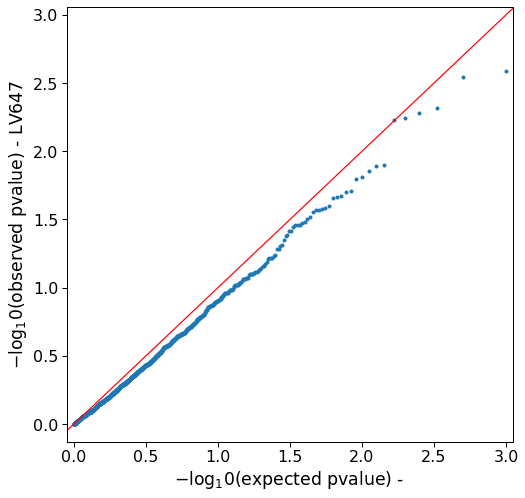

In [125]:
qqplot_unif(results)

**Note**

# Conclusions

Looks like not-well-calibrated LVs are due to either:
* Too many top genes from the same band.
* Or not matched distributions of band sizes between zero and non-zero weighted genes.
* Too many large bands among the top genes.